## 1 Загрузка данных

In [19]:
def preprop(filename):
    
    triplets=[]
    
    with open(filename, 'r') as f:
        ff=f.readlines()
        for i in ff[1:]:
            fff=i.split(',')
            triplets.append([fff[0], fff[1], float(fff[4][:-1])])
    
    print(f'Triplets count: {len(triplets)}')
    
    return triplets

In [35]:
def prepare_triplets(expert):        
    expert_triplets = set()  
    
    for i,j,k in expert:
        for ii, jj, kk in expert:
            cur_triplet = None
            if i==ii and j!=jj:
                if k > kk:
                    cur_triplet = (i, j, i, jj)
                else:
                    cur_triplet = (i, jj, i, j)
            elif i!=ii and j==jj:
                if k > kk:
                    cur_triplet = (j, i, j, ii)
                else:
                    cur_triplet = (j, ii, j, j)
                    
            if cur_triplet and cur_triplet not in expert_triplets:
                expert_triplets.add(cur_triplet)           

    expert_triplets = list(expert_triplets)
    print(expert_triplets[:3])
    print(f'Generated triplets count : {len(expert_triplets)}')
    return expert_triplets

In [36]:
def prepare_quads(expert, reverse=False):
    expert_sort = sorted(expert, key=lambda x: x[2], reverse=reverse)
    print(expert_sort[:3])
    
    expert_quads = []
    for i in range(1,len(expert_sort)):
        expert_quads.append([expert_sort[i-1][0], 
                             expert_sort[i-1][1], 
                             expert_sort[i][0], 
                             expert_sort[i][1]])

    print(expert_quads[:3])
    print(f'Generated quads count : {len(expert_quads)}')
    return expert_quads

In [23]:
def prepare_index(expert_quads):
    goods_vocab = set()
    goods_index = {}
    counter = 0
    goods_pool_indexed = []

    for i in expert_quads:
        for w in i:
            if w not in goods_vocab:
                goods_vocab.add(w)
                goods_index[w] = counter
                counter += 1            

        goods_pool_indexed.append([goods_index[i[0]],
                                   goods_index[i[1]],
                                   goods_index[i[2]],
                                   goods_index[i[3]]                               
                                   ])

    print(f'Vocab size: {len(goods_vocab)}')
    #print(len(goods_pool_indexed))
    #print(goods_pool_indexed[-10:])
    return goods_vocab, goods_index, goods_pool_indexed

## 2 Построение представлений для набора четвёрок

In [24]:
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import spearmanr

import numpy as np
import copy

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [25]:
class PletNet(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.linear = nn.Linear(p, p)#, bias=False)
    
    def forward(self, v):
        return self.linear(v)
    
    def inference(self, v):
        with torch.no_grad():
            #return self.linear(torch.from_numpy(v).float())
            return self.linear(v)

In [26]:
# TripletLoss есть встроенный в torch(может работать быстрее)

class PletLossCos(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    
    def forward(self, batch_i, batch_j, batch_k, batch_l, size_average=True):
        d_ij = 1 - self.cos(batch_i, batch_j)
        d_kl = 1 - self.cos(batch_k, batch_l)
        losses = F.relu(d_ij - d_kl + self.margin)

        return losses.sum() # можно ли сделать лосс число положительных разностей (дискретный лосс) ?

In [27]:
class PletLossEuc(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
        self.pdist = torch.nn.PairwiseDistance(p=2, eps=1e-6)
    
    def forward(self, batch_i, batch_j, batch_k, batch_l, size_average=True):
        d_ij = self.pdist(batch_i, batch_j)
        d_kl = self.pdist(batch_k, batch_l)
        losses = F.relu(d_ij - d_kl + self.margin)

        return losses.sum()

In [28]:
def hand_checker_1(vec, gquads, distance='cosine'):

    a,b,c,d = list(zip(*gquads))    

    batch_i = torch.index_select(vec, 0, torch.tensor(a))
    batch_j = torch.index_select(vec, 0, torch.tensor(b))
    batch_k = torch.index_select(vec, 0, torch.tensor(c))
    batch_l = torch.index_select(vec, 0, torch.tensor(d))
    
    if distance == 'cosine':
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        d_ij = 1 - cos(batch_i, batch_j)
        d_kl = 1 - cos(batch_k, batch_l)
    elif distance == 'euclidean':
        pdist = torch.nn.PairwiseDistance(p=2, eps=1e-6)
        d_ij = pdist(batch_i, batch_j)
        d_kl = pdist(batch_k, batch_l)
            
    diff = d_ij - d_kl
    #print(diff)
    diff[diff > 0] = 0
    diff[diff < 0] = 1

    counter = torch.sum(diff)
    return int(counter)#float(counter / len(gquads))

In [44]:
def hand_checker_2(m, expert, distance='cosine'):
    
    m_pairs=[]
    exp_pairs=[]

    for i,j,k in expert:
        if i in goods_vocab and j in goods_vocab:
            if distance == 'cosine':
                m_pairs.append(cosine(m[goods_index[i]],
                                      m[goods_index[j]]
                                    ))
            elif distance == 'euclidean':
                 m_pairs.append(euclidean(m[goods_index[i]],
                                          m[goods_index[j]]
                                         ))
            exp_pairs.append(100. - k)

    #print(len(m_pairs))
    print(m_pairs[:5], exp_pairs[:5])
    return spearmanr(m_pairs, exp_pairs)[0]

In [98]:
def fit_plet(num_epochs, model, loss_fn, opt, vec, a, b, c, d, distance):
    
    for epoch in tqdm.tqdm(range(num_epochs)):
    
        pred = model(vec)
             
        loss = loss_fn(
                torch.index_select(pred, 0, a),
                torch.index_select(pred, 0, b),
                torch.index_select(pred, 0, c),
                torch.index_select(pred, 0, d)
               )
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        if epoch % 8000 == 0:
            for g in opt.param_groups:
                g['lr'] *= 0.1
        
        if epoch % 1000 == 0:
            #for g in opt.param_groups:
            #    g['lr'] *= 0.1
            #print(hand_checker_1(model.inference(vec.to(device)).cpu(), goods_pool_indexed, distance=distance))
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    return model.inference(vec.to(device)).cpu()###new_vec

## 3 Работа с экспертными данными

In [ ]:
datasets = ["MEN-standartized.csv", 
          "SimLex-999-standartized.csv", 
          "WordSim-353-standartized.csv"]

results = {}

for distance in ['euclidean', 'cosine']:
    results[distance] = {}
    for dataset in datasets:
        results[distance][dataset] = []
        for vec_size in range(100, 0, -5):

            expert = preprop(dataset)    
            #expert_quads = prepare_quads(expert, reverse=True)
            expert_quads = prepare_triplets(expert)
            goods_vocab, goods_index, goods_pool_indexed = prepare_index(expert_quads)

            model = PletNet(vec_size).to(device)
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
            if distance == 'cosine':
                plet_loss = PletLossCos(1)
            elif distance == 'euclidean':
                plet_loss = PletLossEuc(1)

            vec = torch.empty(len(goods_vocab), vec_size)
            nn.init.xavier_normal_(vec)
            print(f'hand_checker_1: {hand_checker_1(vec, goods_pool_indexed, distance)}')
            print(f'hand_checker_2: {hand_checker_2(vec, expert, distance)}')

            a,b,c,d = list(zip(*goods_pool_indexed))

            fit_plet(10000, model, plet_loss, opt, vec.to(device), #gquads
                       torch.tensor(a).to(device),
                       torch.tensor(b).to(device),
                       torch.tensor(c).to(device),
                       torch.tensor(d).to(device),
                       distance
                  )

            new_vec = model.inference(vec.to(device)).cpu()
            print(hand_checker_1(vec, goods_pool_indexed, distance), hand_checker_1(new_vec, goods_pool_indexed, distance))
            print(hand_checker_2(vec, expert), hand_checker_2(new_vec, expert))

            results[distance][dataset].append((vec_size, hand_checker_2(new_vec, expert)))
            _

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

In [ ]:
def create_plot(results, distance='cosine'):
    for i in results[distance]:
        a,b = zip(*results[distance][i])
        plt.plot(a, list(map(abs, b)), label='-'.join(i.split('-')[:-1]))
        plt.legend(loc='upper right')
    plt.xlabel('Embedding size')
    plt.ylabel('Spearman correlation')
    plt.title(f'Results for {distance} distance function')    
    plt.savefig(f'GNMDS_{distance}.png', dpi=100)
    plt.show()

In [ ]:
create_plot(results, 'euclidean')

In [ ]:
create_plot(results, 'cosine')

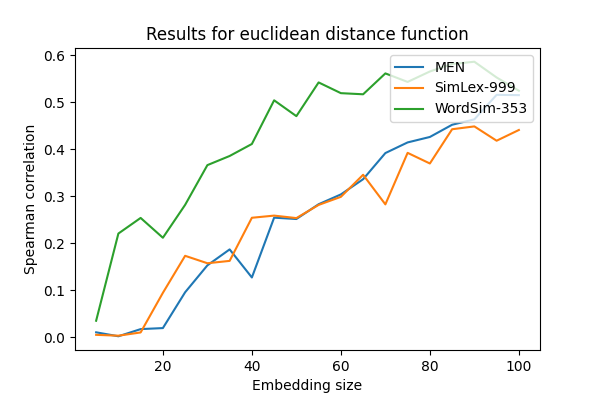

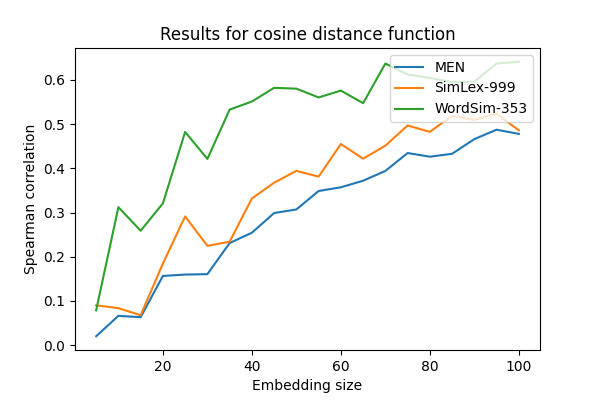

In [6]:
from IPython.display import display, Image

display(Image(filename='GNMDS_euclidean.png'))
display(Image(filename='GNMDS_cosine.png'))